In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver

from SignalAttenuation import Attenuation, AnnualLayerThick

# Load core data of interest 

In [2]:
site = 'SiteB'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']



/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-2-87e24d324b79>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


### Define core sites of interest

In [3]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteG']

# Run through cores and estimate ALT for entire core 

### Define plot windows to plot cores in 

In [4]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(16,10))
plt.close()

### Run trough all cores and plot them respectively

In [5]:
for i,ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]

    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

    coreNames = CoresSpecs['CoreName']

    print(site)
    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]

    depth = np.asarray(data_d18O['depth'])
    d18O = np.asarray(data_d18O['d18O'])

    ALT_inst = AnnualLayerThick(depth, d18O, 7)
    fks, ls, lMean, lStd, secs = ALT_inst.ALT_fullCore_seq(shift=4, printItes=False)
    
    l_LT = np.mean(lMean[(secs > dTamb) & (secs < dLaki)])
    
    ax.step(secs, lMean, where='mid', lw=1.4)
    ax.errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spectral integration (average)')
    ax.set(xlim=(min(secs)-0.5, max(secs)+0.5), xlabel='Depth [m]', ylabel='Annual layer thickness [m]', title=site)
    ax.axvline(dLaki, lw=1, ls='--', c='k')
    ax.axvline(dTamb, lw=1, ls='--', c='k')
    ax.axhline(l_LT, lw=1.3, ls='--', c='b', label = f'ALT at LT: {l_LT:.2f} [m]')
    ax.legend(fontsize=16)

SiteA
Entire core: 1.16-128.634 [m]



<ipython-input-5-bab388b092b3>:14: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


SiteB
Entire core: 1.16-105.605 [m]

SiteD
Entire core: 1.242-100.066 [m]

SiteG
Entire core: 1.16-70.84 [m]



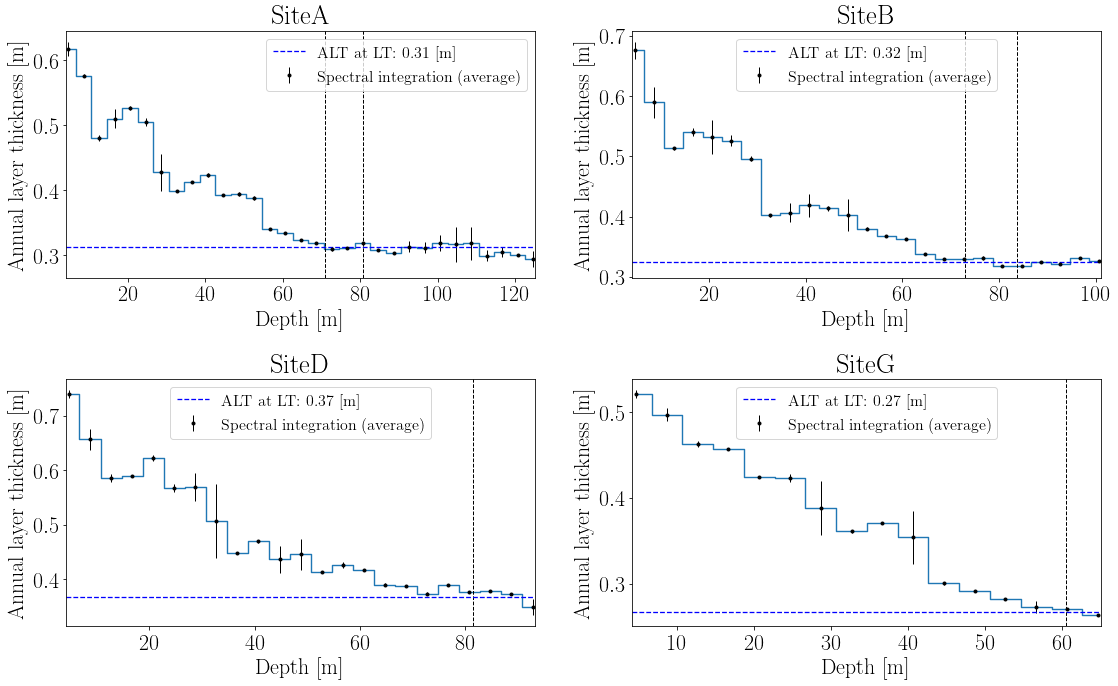

In [6]:
fig.tight_layout()
fig

In [7]:
saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'
if saveFigs:
    fig.savefig(pathFigures + 'AllCores_ALT_l5_s4.pdf', bbox_inches='tight')

# Example of spectral ALT estimation through different transforms

### Defining a given data and depth to examine

In [8]:
site = 'SiteB'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']



/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-8-87e24d324b79>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


### Define interpolation function

In [9]:
def interpData(d,x, DeltaInput=False, DeltaIn=0.):

        if DeltaInput:
            Delta = DeltaIn
        else:
            diff = np.diff(d)
            Delta = round(min(diff), 3)

        d_min = Delta * np.ceil(d[0]/Delta)
        d_max = Delta * np.floor(d[-1]/Delta)

        n = int(1 + (d_max - d_min)/Delta)

        j_arr = np.linspace(0,n,n)
        dhat0 = d_min + (j_arr - 1)*Delta

        f = interpolate.CubicSpline(d,x)

        xhat0 = f(dhat0)

        dhat = dhat0[(dhat0 >= min(d)) & (dhat0 <= max(d))]
        xhat = xhat0[(dhat0 >= min(d)) & (dhat0 <= max(d))]

        return dhat, xhat, Delta



In [10]:
cutOff_High = 0
cutOff_Low = cutOff_High + 5#max(depth)

depthTop = np.asarray(depth[(depth > cutOff_High) & (depth < cutOff_Low)])
d18OTop = np.asarray(d18O[(depth > cutOff_High) & (depth < cutOff_Low)])

DeltaMean = np.mean(np.diff(depthTop))/2

dHat, xHat, Delta = interpData(depthTop, d18OTop, True, DeltaIn = DeltaMean)


### Make instances of attenuation class and compute various spectral transforms of data

In [11]:
AttInst = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'DCT')
dataDCT, keysDCT = AttInst()

AttInst2 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'NDCT')
dataNDCT, keysNDCT = AttInst2()

AttInst3 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'FFT')
dataFFT, keysFFT = AttInst3()

AttInst4 = Attenuation(depthTop, d18OTop, 0, PSD_Type = 'MEM')
dataMEM, keysMEM = AttInst4()


### Define variables and parameters of interest

In [12]:
wDCT = AttInst.w
PDCT = AttInst.P

wNDCT = AttInst2.w
PNDCT = AttInst2.P

wFFT = AttInst3.w
PFFT = AttInst3.P

wMEM = AttInst4.w
PMEM = AttInst4.P


fkDCT = wDCT[dataDCT[0].astype(int)]
hsDCT = dataDCT[1]

fkNDCT = wNDCT[dataNDCT[0].astype(int)]
hsNDCT = dataNDCT[1]

fkFFT = wFFT[dataFFT[0].astype(int)]
hsFFT = dataFFT[1]


idMEM = signal.find_peaks(PMEM, height=0.025)[0]
fkMEM = dataMEM[0]
PkMEM = dataMEM[1]
hsMEM = PMEM[idMEM]
fkkMEM = wMEM[idMEM]

idMax = np.where(hsMEM == max(hsMEM))[0][0]
fkMax = fkkMEM[idMax]
hMax = hsMEM[idMax]

### Plot spectral data for investigation

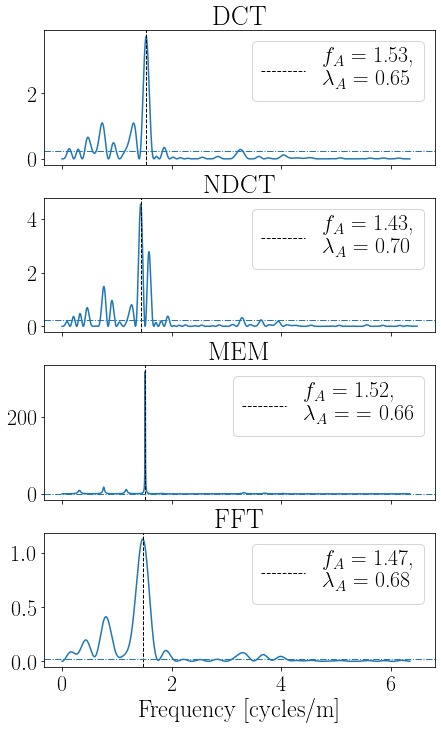

In [15]:
fig, ax = plt.subplots(4,1,figsize=(6,10), sharex=True)

ax[0].plot(wDCT, PDCT)
ax[0].axvline(fkDCT[0], lw=1,c='k',ls='--', label=f'$f_A$ = {fkDCT[0]:.2f}, \n$\lambda_A$ = {1/fkDCT[0]:.2f}')
ax[0].set(title='DCT')
ax[0].axhline(0.25,lw=1,ls='-.')
ax[0].legend()

ax[1].plot(wNDCT, PNDCT)
ax[1].axvline(fkNDCT[0], lw=1,c='k',ls='--', label=f'$f_A$ = {fkNDCT[0]:.2f}, \n$\lambda_A$ = {1/fkNDCT[0]:.2f}')
ax[1].set(title='NDCT')
ax[1].axhline(0.25,lw=1,ls='-.')
ax[1].legend()

ax[2].plot(wMEM, PMEM)
ax[2].axvline(fkMax, lw=1,c='k',ls='--', label=f'$f_A$ = {fkMax:.2f}, \n$\lambda_A$ =  = {1/fkMax:.2f}')
ax[2].set(title='MEM')
ax[2].axhline(0.25,lw=1,ls='-.')
ax[2].legend()

ax[3].plot(wFFT, PFFT)
ax[3].axvline(fkFFT[0], lw=1,c='k',ls='--', label=f'$f_A$ = {fkFFT[0]:.2f}, \n$\lambda_A$ = {1/fkFFT[0]:.2f}')
ax[3].set(title='FFT')#, 
ax[3].set_xlabel('Frequency [cycles/m]', fontsize=24)
ax[3].axhline(0.025,lw=1,ls='-.')
ax[3].legend()
fig.tight_layout(pad=0.1)
#ax[0].set(xlim=(0,4))

In [16]:
saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'
if saveFigs:
    fig.savefig(pathFigures + site + 'ALTestimate_example.pdf', bbox_inches='tight')